# Dog Breed Classifier

<img src="0fc12a365adfcbb603e298b10149632a.jpg" style="width:1200px;height:400px;">

This notebook leverages a pretrained InceptionV3 model (on ImageNet) to prepare a _Dog Breed Classifier_.

It showcases how __Transfer Learning__ can be utilized to prepare high performing models

In [1]:
%matplotlib inline

In [2]:
# Pandas and Numpy for data structures and util fucntions
import numpy as np
import pandas as pd
from numpy.random import rand

pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn.model_selection import train_test_split

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation,Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Load Dataset

The Stanford Dog breed dataset is available at [Kaggle/Dogbreed](https://www.kaggle.com/c/dog-breed-identification/data).

The download consists of train, test and label files

In [4]:
train_folder = 'train/'
test_folder = 'test/'

In [6]:
# kaggle에서 받은 데이터
data_labels = pd.read_csv('labels.csv')
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Check Number of Classes in the Dataset

The dataset contain 120 different dog breeds

In [7]:
target_labels = data_labels['breed']
len(set(target_labels))

120

## Prepare Labels
Deep Learning models work with one hot encoded outputs or target variables. We utilize pandas to prepare one hot encoding for the labels.

In [8]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
print(labels_ohe.shape)
print(labels_ohe[:2])

(10222, 120)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


We add another column to the labels dataset to identify image path

In [9]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["id"] + ".jpg" ), axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


## Prepare Train-Test Datasets
We use a 70-30 split to prepare the two dataset. 

In [10]:
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=(299, 299))
                       ) for img 
                           in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

In [11]:
train_data.shape

(10222, 299, 299, 3)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [13]:
x_train.shape, x_test.shape

((7155, 299, 299, 3), (3067, 299, 299, 3))

Prepare Validation Dataset

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [15]:
x_train.shape, x_val.shape

((6081, 299, 299, 3), (1074, 299, 299, 3))

Prepare target variables for train, test and validation datasets

In [16]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).as_matrix()
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((6081, 120), (3067, 120), (1074, 120))

## Data Augmentation

Since number of samples per class are not very high, we utilize data augmentation to prepare different variations of different samples available. We do this using the ```ImageDataGenerator utility``` from ```keras```

In [17]:
BATCH_SIZE = 32

In [18]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [19]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

## Prepare Deep Learning Classifier

* Load InceptionV3 pretrained on ImageNet without its top/classification layer
* Add additional custom layers on top of InceptionV3 to prepare custom classifier

In [20]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 9s 0us/step


In [21]:
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

* Stack the two models (InceptionV3 and custom layers) on top of each other 
* Compile the model and view its summary

In [22]:
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

## Model Training
We train the model with a Batch Size of 32 for just 15 Epochs.

The model utilizes the power of transfer learning to achieve a validation accuracy of about __81%__ !

In [25]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              verbose=1)

Epoch 1/15
191/191 [==============================] - 92s 481ms/step - loss: 1.0324 - acc: 0.7255 - val_loss: 0.7090 - val_acc: 0.7914
Epoch 2/15
191/191 [==============================] - 86s 448ms/step - loss: 0.9525 - acc: 0.7440 - val_loss: 0.7119 - val_acc: 0.7886
Epoch 3/15
191/191 [==============================] - 87s 453ms/step - loss: 0.8918 - acc: 0.7537 - val_loss: 0.6621 - val_acc: 0.7877
Epoch 4/15
191/191 [==============================] - 89s 465ms/step - loss: 0.8298 - acc: 0.7693 - val_loss: 0.6609 - val_acc: 0.7970
Epoch 5/15
191/191 [==============================] - 88s 461ms/step - loss: 0.8175 - acc: 0.7690 - val_loss: 0.6189 - val_acc: 0.8035
Epoch 6/15
191/191 [==============================] - 87s 455ms/step - loss: 0.7677 - acc: 0.7834 - val_loss: 0.6668 - val_acc: 0.7952
Epoch 7/15
191/191 [==============================] - 89s 466ms/step - loss: 0.7284 - acc: 0.7931 - val_loss: 0.6855 - val_acc: 0.7821
Epoch 8/15
191/191 [==============================] - 8

Save the Model

In [26]:
model.save('dog_breed.hdf5')

## Visualize Model Performance

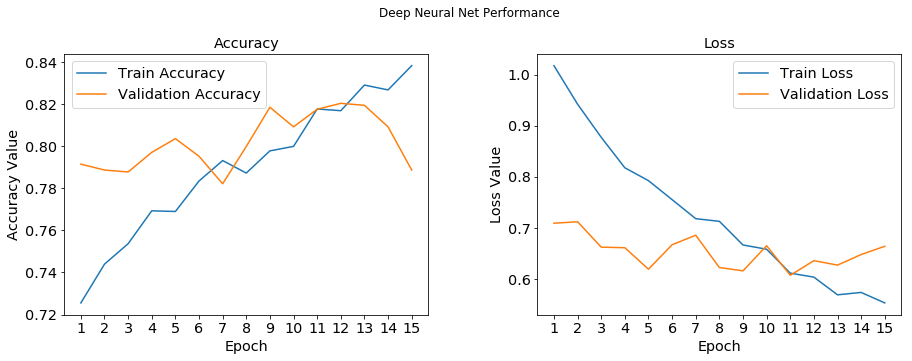

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Test Model Performance

Step 1 is to prepare the training dataset. Since we scaled training data, test data should also be scaled in a similar manner. 

_Note: Deep Learning models are very sensitive to scaling._

In [28]:
# scaling test features
x_test /= 255.

In [29]:
test_predictions = model.predict(x_test)
test_predictions

array([[4.69518454e-06, 4.86297267e-06, 3.83020188e-06, ...,
        3.09120566e-02, 2.14240822e-06, 6.02706052e-07],
       [4.47708430e-07, 1.79059541e-07, 8.03198509e-06, ...,
        9.12204501e-04, 5.69741940e-04, 6.30537324e-05],
       [4.58433578e-06, 3.69117083e-06, 2.71440314e-07, ...,
        3.20407389e-06, 7.91658840e-06, 8.27428630e-06],
       ...,
       [4.33403045e-07, 1.50461702e-07, 8.32458852e-07, ...,
        3.92415757e-07, 2.61508626e-06, 3.12132187e-07],
       [5.21220136e-06, 2.80412087e-06, 2.51924462e-06, ...,
        1.99264250e-05, 5.57185231e-05, 6.93800985e-06],
       [1.03971914e-07, 4.43950142e-07, 3.44287650e-06, ...,
        7.20797715e-08, 3.73313560e-06, 1.55837071e-04]], dtype=float32)

In [30]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,4.695185e-06,4.862973e-06,3.830202e-06,1.336707e-06,1.951471e-02,3.525950e-06,4.688692e-08,1.379984e-05,4.381965e-06,2.738488e-05,...,1.475205e-07,3.655552e-07,1.163726e-04,1.144418e-04,5.236609e-04,2.801243e-07,5.829078e-07,3.091206e-02,0.000002,6.027061e-07
1,4.477084e-07,1.790595e-07,8.031985e-06,4.272383e-06,6.613731e-04,3.096749e-05,2.091580e-05,7.033066e-04,6.311085e-06,6.148708e-03,...,4.460757e-05,2.282364e-02,2.087046e-06,7.436839e-05,2.516160e-03,1.408576e-06,1.661312e-05,9.122045e-04,0.000570,6.305373e-05
2,4.584336e-06,3.691171e-06,2.714403e-07,1.034582e-04,6.307416e-05,8.274845e-01,3.941979e-05,6.971832e-04,1.094566e-04,1.987395e-05,...,2.058698e-06,4.855434e-06,7.405823e-07,3.859814e-05,5.823942e-06,8.642536e-07,2.832286e-05,3.204074e-06,0.000008,8.274286e-06
3,5.900690e-08,4.945312e-05,5.335308e-07,2.568927e-06,3.161908e-08,5.174688e-08,1.899254e-07,8.880908e-08,1.282124e-05,1.589551e-06,...,5.675177e-05,4.074959e-08,8.334047e-08,1.538349e-07,9.876337e-07,1.797046e-05,9.155285e-07,1.647202e-08,0.000002,8.531126e-07
4,1.851203e-07,2.554229e-07,2.522933e-07,5.424474e-08,5.255889e-07,3.579011e-08,1.484578e-07,5.819519e-09,7.837733e-08,1.236348e-07,...,5.493331e-07,1.990565e-06,1.519428e-08,3.614554e-08,8.602468e-08,3.798117e-09,3.775115e-03,1.979467e-07,0.000058,7.479177e-07


In [31]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['rhodesian_ridgeback',
 'italian_greyhound',
 'appenzeller',
 'cocker_spaniel',
 'sealyham_terrier',
 'borzoi',
 'chow',
 'bluetick',
 'tibetan_mastiff',
 'malinois']

## Analyze Test Performance

In [32]:
import model_evaluation_utils as meu

In [33]:
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

Accuracy: 0.8719
Precision: 0.883
Recall: 0.8719
F1 Score: 0.8691


In [34]:
meu.display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(labels_ohe_names.columns))

                                precision    recall  f1-score   support

                 affenpinscher       0.95      0.83      0.89        24
                  afghan_hound       1.00      0.97      0.99        35
           african_hunting_dog       1.00      0.92      0.96        26
                      airedale       0.86      1.00      0.93        32
american_staffordshire_terrier       0.58      0.64      0.61        22
                   appenzeller       0.62      0.78      0.69        23
            australian_terrier       0.90      0.90      0.90        31
                       basenji       1.00      0.88      0.94        33
                        basset       0.86      0.96      0.91        25
                        beagle       0.91      0.94      0.92        31
            bedlington_terrier       1.00      1.00      1.00        27
          bernese_mountain_dog       0.92      1.00      0.96        34
       black-and-tan_coonhound       0.80      0.87      0.83  

In [36]:
meu.display_confusion_matrix(true_labels=test_labels, 
                                    predicted_labels=predictions, 
                                    classes=list(labels_ohe_names.columns))

                                          Predicted:               \
                                       affenpinscher afghan_hound   
Actual: affenpinscher                             20            0   
        afghan_hound                               0           34   
        african_hunting_dog                        0            0   
        airedale                                   0            0   
        american_staffordshire_terrier             0            0   
        appenzeller                                0            0   
        australian_terrier                         0            0   
        basenji                                    0            0   
        basset                                     0            0   
        beagle                                     0            0   
        bedlington_terrier                         0            0   
        bernese_mountain_dog                       0            0   
        black-and-tan_coonhound   

The model achieves a test accuracy of approximately __86%__

## Visualize Model Performance
Visualize model performance with actual images, labels and prediction confidence

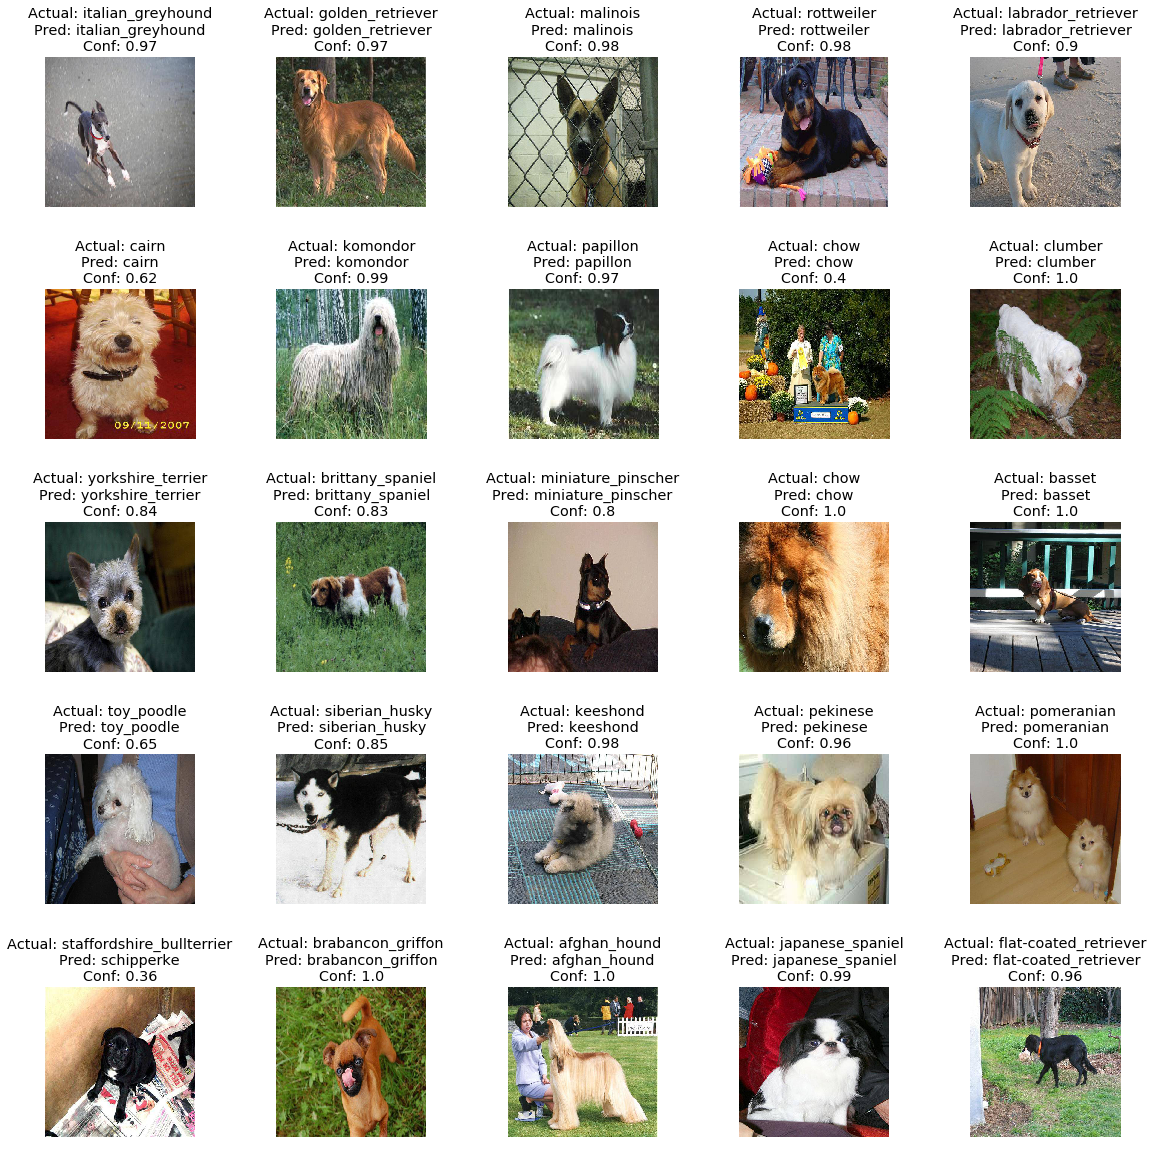

In [37]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)    